# Load mask from JuBrain and adjust

In [18]:
import numpy as np
import nibabel as nib
from nilearn import plotting,image
from nilearn.image import resample_img
import pandas as pd
import os
from os.path import join, split

In [11]:
occipital_mask_path = '/Users/danieljanini/Documents/MATLAB/Anatomy/JuBrain_ROIs/occipital_mask.nii.gz'
occipital_mask = image.load_img(occipital_mask_path)
mask = occipital_mask.get_fdata()

In [12]:
mask.shape

(193, 229, 193)

In [13]:
brain_mask.affine

array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [15]:
# Define the new target affine and shape
target_affine = np.array([
    [2., 0., 0., -76.],
    [0., 2., 0., -112.],
    [0., 0., 2., -76.],
    [0., 0., 0., 1.]
])
target_shape = (77, 95, 82)

# Resample the mask
resampled_mask = resample_img(
    occipital_mask,
    target_affine=target_affine,
    target_shape=target_shape,
    interpolation='nearest'  # IMPORTANT: 'nearest' for masks to keep binary values
)

In [17]:
resampled_mask.affine

array([[   2.,    0.,    0.,  -76.],
       [   0.,    2.,    0., -112.],
       [   0.,    0.,    2.,  -76.],
       [   0.,    0.,    0.,    1.]])

/opt/anaconda3/envs/my_python_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



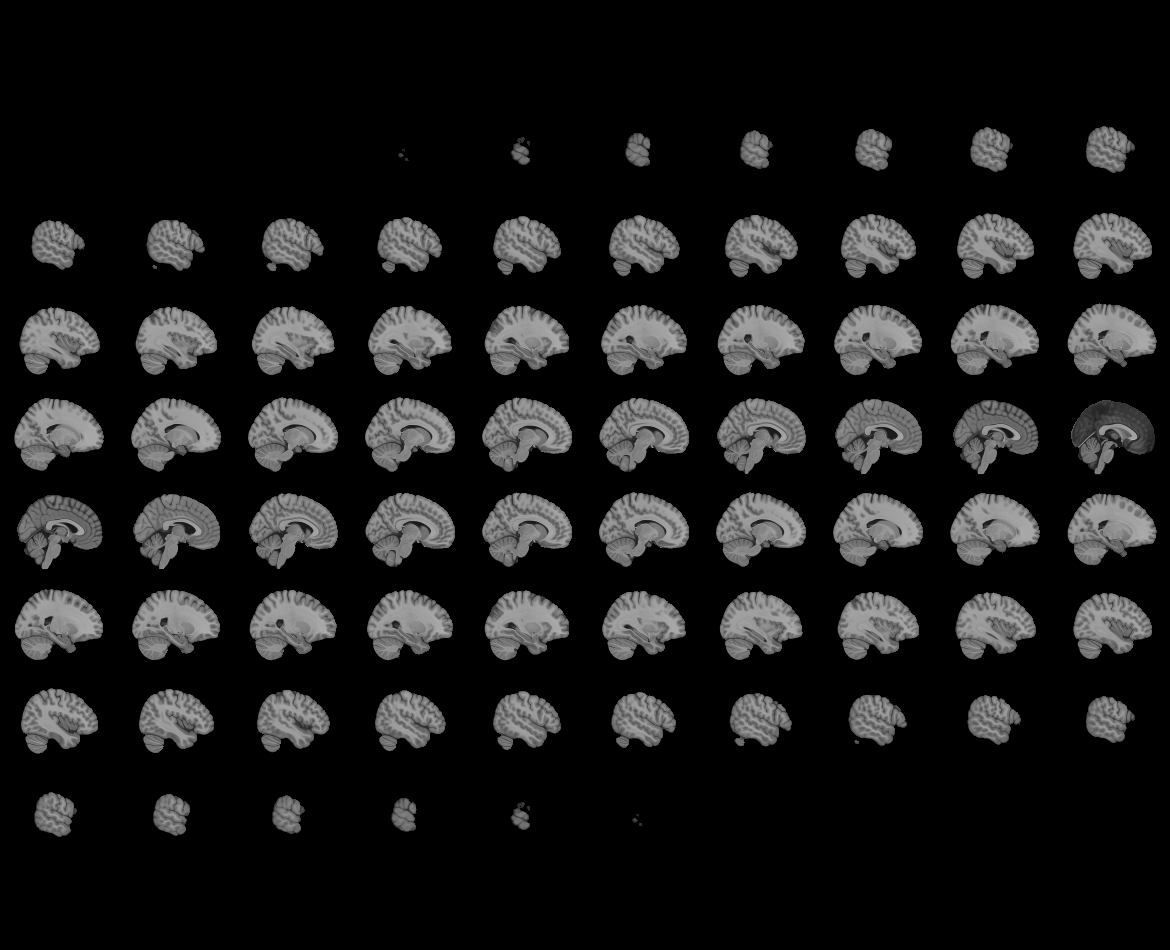
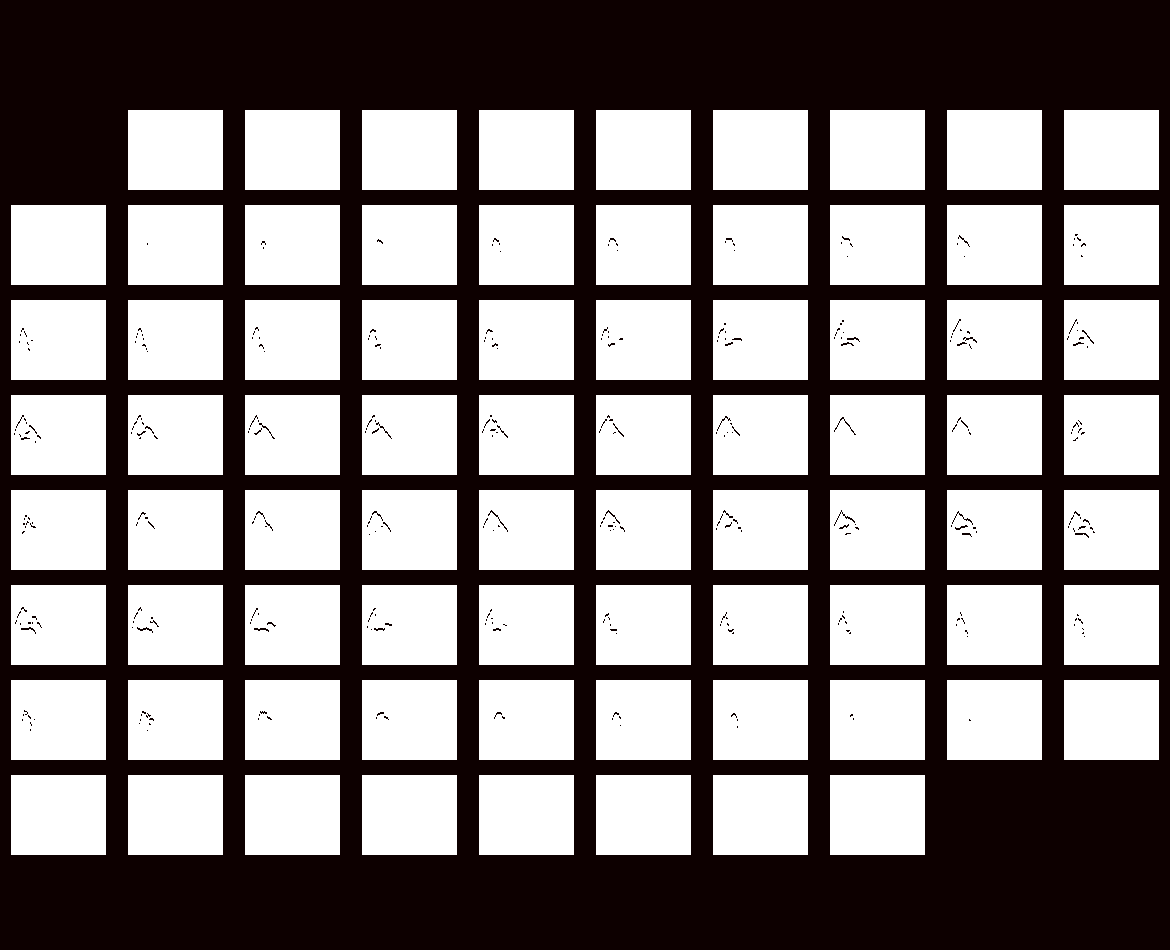

In [19]:
plotting.view_img(resampled_mask)

In [20]:
resampled_mask.to_filename('/Users/danieljanini/Documents/Thesis/Code/occipital_mask.nii.gz')

In [21]:
from itertools import combinations

elements = [0, 1, 2, 3, 4, 5]

# Get all combinations of 3 elements
group1_list = list(combinations(elements, 3))

# To avoid duplicates (like (group1, group2) and (group2, group1)), only keep half
splits = []
seen = set()

for group1 in group1_list:
    group2 = tuple(sorted(set(elements) - set(group1)))
    # Make sure we haven't already seen this partition
    key = tuple(sorted([group1, group2]))
    if key not in seen:
        seen.add(key)
        splits.append((group1, group2))

print(f"Number of splits: {len(splits)}")
for split in splits:
    print(split)


Number of splits: 10
((0, 1, 2), (3, 4, 5))
((0, 1, 3), (2, 4, 5))
((0, 1, 4), (2, 3, 5))
((0, 1, 5), (2, 3, 4))
((0, 2, 3), (1, 4, 5))
((0, 2, 4), (1, 3, 5))
((0, 2, 5), (1, 3, 4))
((0, 3, 4), (1, 2, 5))
((0, 3, 5), (1, 2, 4))
((0, 4, 5), (1, 2, 3))


In [26]:
split[0]

(0, 4, 5)

In [30]:
import numpy as np
import nibabel as nib
from nilearn import plotting, image
import pandas as pd
import os
import glob
from os.path import join, exists, split
from scipy.stats import pearsonr
import re

outdir = '/Users/danieljanini/Documents/Thesis/miniblock/Outputs/'
homedir = split(os.getcwd())[0]
datadir = '/Users/danieljanini/Documents/Thesis/miniblock/'
presdir = join(homedir, 'Behavior', 'designmats')
subs = ["01", "02", "03","04", "05","06", "07", "08", "10", "11", "12", "13", "14", "15", "17", "18", "19"]
smooths = ["sm_2_vox", "unsmoothed"]
runtypes = ['miniblock', "sus", "er"]

# Define affine (identity or use a real affine if you have one)
affine = target_affine

for sub in subs: 
    for smoothing in smooths: 
        for runtype in runtypes: 

            results_glmsingle = dict()
            results_glmsingle['typed'] = np.load(join(outdir,f'sub-{sub}',f'{smoothing}_sub-{sub}_{runtype}/TYPED_FITHRF_GLMDENOISE_RR.npy'), allow_pickle=True).item()
            betas = results_glmsingle['typed']['betasmd']



            # Output folder for NIfTIs
            save_dir = join(outdir, f'sub-{sub}', f'{smoothing}_sub-{sub}_{runtype}', 'nifti_betas')
            os.makedirs(save_dir, exist_ok=True)

            # Define affine (identity or use a real affine if you have one)
            affine = target_affine

            # Loop over trials and save each one
            n_trials = betas.shape[-1]
            for i in range(n_trials):
                beta_data = betas[..., i]  # Take 3D volume for trial i
                nii = nib.Nifti1Image(beta_data, affine)
                nib.save(nii, join(save_dir, f'beta_{i+1:04d}.nii'))
    


Saved 240 beta images in /Users/danieljanini/Documents/Thesis/miniblock/Outputs/sub-19/unsmoothed_sub-19_er/nifti_betas


In [31]:
# Load and process design matrix
pattern = presdir + f'/P0{sub}_ConditionRich_Run*_{runtype}.csv'
matches = glob.glob(pattern)
matches.sort()
design = []
for i in range(len(matches)):
    designMat = pd.read_csv(matches[i], header=None)
    num = re.search(r'Run_(\d+)', matches[i])
    runNum = int(num.group(1))
    # Adjust runNum for interspersed localizer runs
    if (runNum > 3) & (runNum < 7) & (sub != '01'): 
        runNum += 1
    elif (runNum >= 7):
        runNum += 2
    elif (sub == '01') & (runNum > 4) & (runNum < 7):
        runNum += 1
    design.append(designMat)

all_design = np.vstack((design[0], design[1], design[2]))
condition_mask = all_design.sum(axis=1) > 0
condition_vector = np.argmax(all_design[condition_mask], axis=1)
n_conditions = 40
max_reps = 6

repindices = np.full((max_reps, n_conditions), np.nan)
for p in range(n_conditions):  
    inds = np.where(condition_vector == p)[0]  
    repindices[:len(inds), p] = inds  

In [35]:
repindices[:,1]

array([ 23.,  64., 104., 141., 166., 217.])

In [59]:
res_accuracy_path = '/Users/danieljanini/Documents/Thesis/miniblock/Outputs/decoding/searchlight/sus/sub-01/res_accuracy_minus_chance.nii'
decoding_results = image.load_img(res_accuracy_path)

/opt/anaconda3/envs/my_python_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



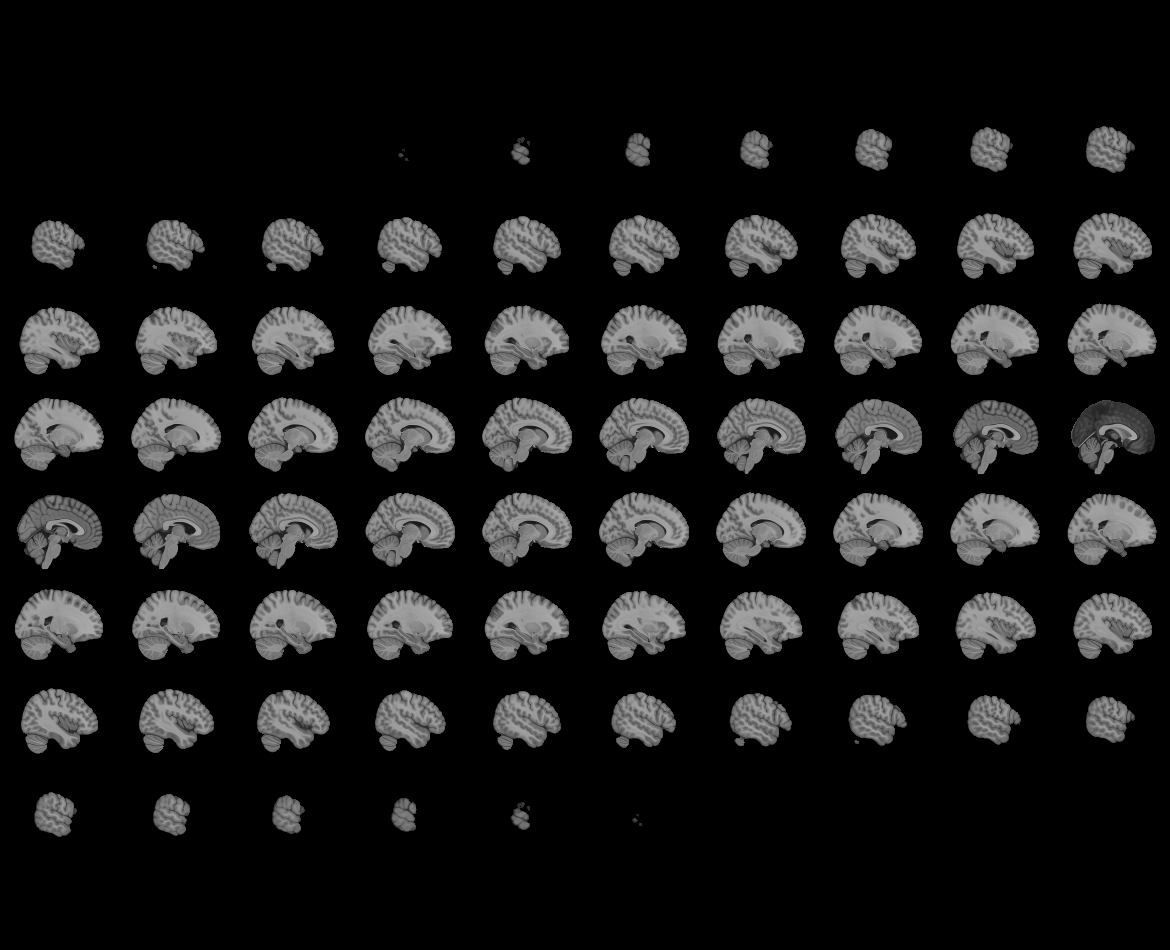
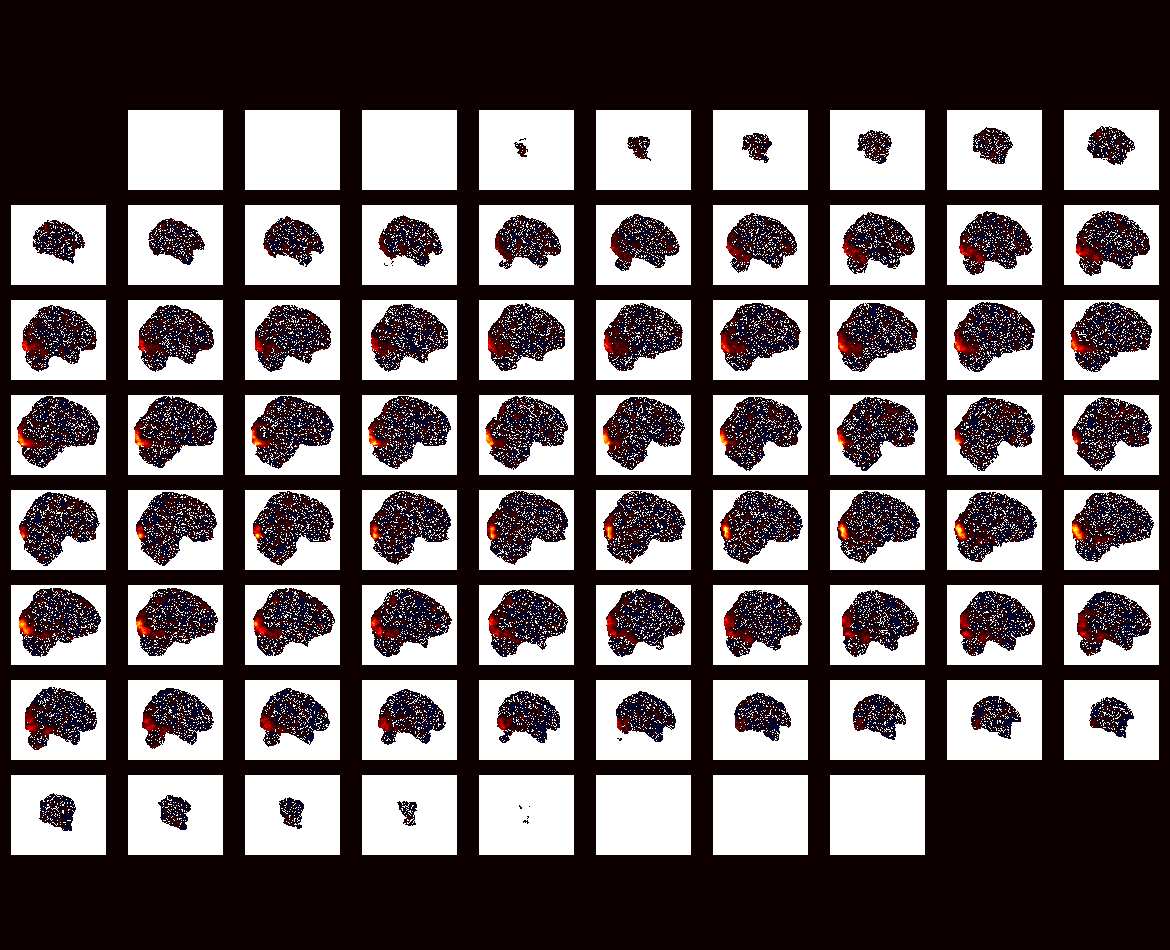

In [60]:
plotting.view_img(decoding_results)

## Mask over all participants 

In [47]:
sub = "01"
subs = ["01", "02", "03","04", "05","06", "07", "08", "10", "11", "12", "13", "14", "15", "17", "18", "19"]

brain_mask = image.load_img(join(datadir, 'derivatives', f'sub-{sub}', 'func', f'sub-{sub}_task-func_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'))
mask = brain_mask.get_fdata()

for sub in subs: 
    new_brain_mask = image.load_img(join(datadir, 'derivatives', f'sub-{sub}', 'func', f'sub-{sub}_task-func_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'))
    new_mask = new_brain_mask.get_fdata()
    mask = np.logical_and(mask, new_mask)


In [56]:
np.sum(mask[:,:,:])

203359

In [58]:
group_mask = nib.Nifti1Image(mask.astype(np.float32), brain_mask.affine)
nib.save(group_mask, "/Users/danieljanini/Documents/Thesis/Code/group_mask.nii")